In [1]:
#MNIST image classifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transformation = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.381,))])

train_dataset = datasets.MNIST('data/', train=True, transform=transformation, download=True)
test_dataset = datasets.MNIST('data/', train=False, transform=transformation, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


In [3]:
sample_data = next(iter(train_loader))

In [4]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3801
    image = ((mean*image)+std)
    plt.imshow(image, cmap='gray')

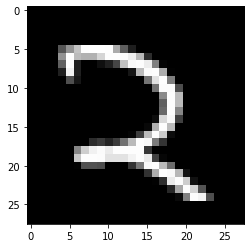

In [5]:
plot_img(sample_data[0][2])

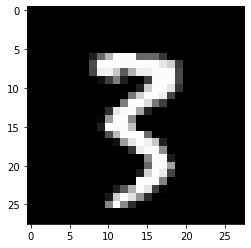

In [6]:
plot_img(sample_data[0][1])

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)
        
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)
                   

In [8]:
model = Net()
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True
if is_cuda:
    model.cuda()

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [10]:
data, target = next(iter(train_loader))

In [11]:
output = model(Variable(data))

In [12]:
output.size()

torch.Size([32, 10])

In [13]:
target.size()

torch.Size([32])

In [14]:
def fit(epoch, model, data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = Variable(data, volatile), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        running_loss += F.nll_loss(output, target, reduction='sum').item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        
        if phase == 'training':
            loss.backward()
            optimizer.step()
            
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss, accuracy

In [15]:
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1,20):
    print("-"*10, epoch)
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase='validation')
    
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

---------- 1
training loss is  0.67 and training accuracy is 47591/60000     79.32
validation loss is  0.18 and validation accuracy is 9477/10000     94.77
---------- 2
training loss is  0.22 and training accuracy is 56235/60000     93.72
validation loss is  0.11 and validation accuracy is 9672/10000     96.72
---------- 3
training loss is  0.16 and training accuracy is 57132/60000     95.22
validation loss is 0.081 and validation accuracy is 9750/10000      97.5
---------- 4
training loss is  0.14 and training accuracy is 57559/60000     95.93
validation loss is 0.064 and validation accuracy is 9801/10000     98.01
---------- 5
training loss is  0.12 and training accuracy is 57900/60000      96.5
validation loss is 0.066 and validation accuracy is 9789/10000     97.89
---------- 6
training loss is  0.11 and training accuracy is 58047/60000     96.75
validation loss is 0.053 and validation accuracy is 9824/10000     98.24
---------- 7
training loss is   0.1 and training accuracy is 582

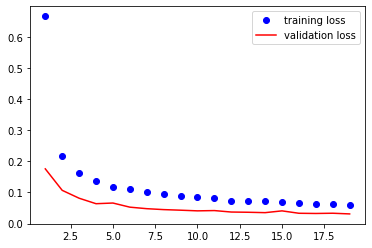

In [17]:
plt.plot(range(1,len(train_losses)+1), train_losses, 'bo',label='training loss')
plt.plot(range(1,len(val_losses)+1), val_losses, 'r',label='validation loss')
plt.legend()

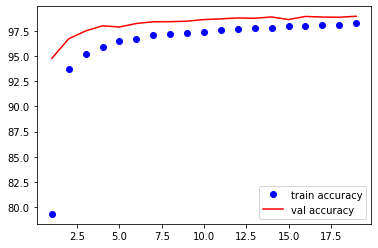

In [20]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'bo', label='train accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label='val accuracy')
plt.legend()

In [21]:
#Understanding 1D convolutions
conv = nn.Conv1d(1,1,3, bias=False)

In [22]:
conv.weight

Parameter containing:
tensor([[[-0.4218, -0.4986, -0.0179]]], requires_grad=True)

In [23]:
sample = torch.randn(1,1,7)

In [24]:
sample

tensor([[[-1.0585, -0.0456,  0.3148, -1.9250, -0.8552, -0.5562, -1.0980]]])

In [25]:
conv(Variable(sample))

tensor([[[ 0.4636, -0.1032,  0.8423,  1.2484,  0.6577]]],
       grad_fn=<SqueezeBackward1>)

In [26]:
#Understanding How padding works
conv = nn.Conv1d(1,1,3,padding=2, bias=False)
conv.weight

Parameter containing:
tensor([[[0.1351, 0.1103, 0.0910]]], requires_grad=True)

In [27]:
sample = torch.randn(1,1,7)
sample

tensor([[[-0.7185, -0.8500,  1.3965,  0.0114,  0.8719, -0.2459,  2.4481]]])

In [28]:
conv(Variable(sample))

tensor([[[-0.0654, -0.1566, -0.0636,  0.0402,  0.2693,  0.0753,  0.3136,
           0.2367,  0.3308]]], grad_fn=<SqueezeBackward1>)